In [1]:
import os
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from keras import optimizers
from keras.applications import VGG16
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
base_dir = 'cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [3]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points


def plot_loss(loss_values, val_loss_values, smooth=False):
    epochs = range(1, len(loss_values) + 1)

    if smooth:
        loss_values = smooth_curve(loss_values)
        val_loss_values = smooth_curve(val_loss_values)

    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def plot_accuracy(acc, val_acc, smooth=False):
    epochs = range(1, len(acc) + 1)

    if smooth:
        acc = smooth_curve(acc)
        val_acc = smooth_curve(val_acc)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [7]:
if __name__ == "__main__":

    conv_base = VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(150, 150, 3))

    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    conv_base.trainable = False

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

    validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.Adam(lr=2e-5),
                  metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________
Found 2000 imag

In [8]:
    # Feature extraction with data augmentation

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=100,
        epochs=30,
        validation_data=validation_generator,
        validation_steps=50)

Epoch 1/30
100/100 [==============================] - 22s 221ms/step - loss: 0.7184 - acc: 0.5730 - val_loss: 0.4900 - val_acc: 0.8030
Epoch 2/30
100/100 [==============================] - 20s 202ms/step - loss: 0.5725 - acc: 0.7000 - val_loss: 0.4099 - val_acc: 0.8300
Epoch 3/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4998 - acc: 0.7640 - val_loss: 0.3720 - val_acc: 0.8500
Epoch 4/30
100/100 [==============================] - 21s 205ms/step - loss: 0.4737 - acc: 0.7740 - val_loss: 0.3471 - val_acc: 0.8640
Epoch 5/30
100/100 [==============================] - 20s 201ms/step - loss: 0.4383 - acc: 0.7975 - val_loss: 0.3243 - val_acc: 0.8820
Epoch 6/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4272 - acc: 0.7965 - val_loss: 0.3110 - val_acc: 0.8820
Epoch 7/30
100/100 [==============================] - 20s 202ms/step - loss: 0.4098 - acc: 0.8120 - val_loss: 0.2995 - val_acc: 0.8860
Epoch 8/30
100/100 [==============================] - 2

KeyboardInterrupt: 

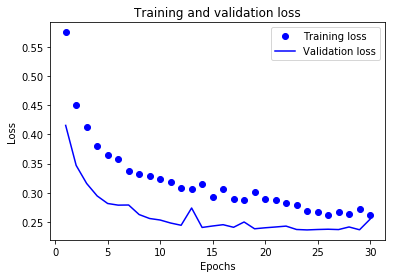

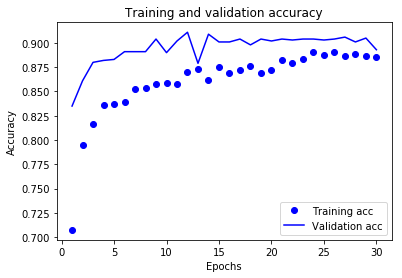

In [6]:
    history_dict = history.history
    plot_loss(history_dict['loss'], history_dict['val_loss'])
    plt.clf()
    plot_accuracy(history_dict['acc'], history_dict['val_acc'])

In [ ]:
 
    # Feature tuning (top 3 layers of VGG16) once the dense classifier
    # has been properly trained

    conv_base.trainable = True

    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1e-5),
                  metrics=['acc'])

    history = model.fit_generator(
        train_generator,
        steps_per_epochs=100,
        epochs=100,
        validation_data=validation_generator,
        validation_steps=50)

    history_dict = history.history
    plot_loss(history_dict['loss'], history_dict['val_loss'], smooth=True)
    plt.clf()
    plot_accuracy(history_dict['acc'], history_dict['val_acc'], smooth=True)

    # Final evaluation
    test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
    print('test acc:', test_acc)
